In [7]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import sys
sys.path.append('../creme/')
import custom_model
import creme
import utils
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pyranges as pr
import shutil
import pickle, os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Necessity

In [72]:
test_results = glob.glob('../results/necessity_test/enformer/*pickle')

In [73]:
track_index = [4824, 5110, 5111]
target_df = pd.read_csv(f'../data/enformer_targets_human.txt', sep='\t')
cell_lines = [utils.clean_cell_name(target_df.iloc[t]['description']) for t in track_index]
tile_coords = pd.read_csv('../old_results//sufficiency_test/enformer/tile_coordinates.csv', index_col='Unnamed: 0').T
cre_tile_coords = tile_coords.loc[[t for t in tile_coords.index if 'tss' not in t]]

In [74]:
result_summary = {}
for c, cell_line in enumerate(cell_lines):
    normalized_effects = []
    cell_line_context = pd.read_csv(f'../results/context_dependence_test/enformer/{cell_line}_context.csv')
    print(c, cell_line)
    for _, row in cell_line_context.iterrows():
        res_path = row['path'].replace('context_dependence_test', 'necessity_test')
        res_raw = utils.read_pickle(res_path) 
        res = {k: r[:, :, c].mean(axis=1) for k, r in res_raw.items()}
        # res['mut'] = np.delete(res['mut'], 19)
        one_seq = pd.DataFrame((res['wt'] - res['mut']) / res['wt'])
        one_seq.columns = ['Normalized shuffle effect']
        one_seq['seq_id'] = res_path.split('/')[-1].split('.')[0]
        one_seq['tile_start'] = cre_tile_coords[0].values
        one_seq['tile_end'] = cre_tile_coords[1].values
        one_seq['context'] = row['context']
        normalized_effects.append(one_seq)
    result_summary[cell_line] = pd.concat(normalized_effects)

0 PC-3
1 GM12878
2 K562


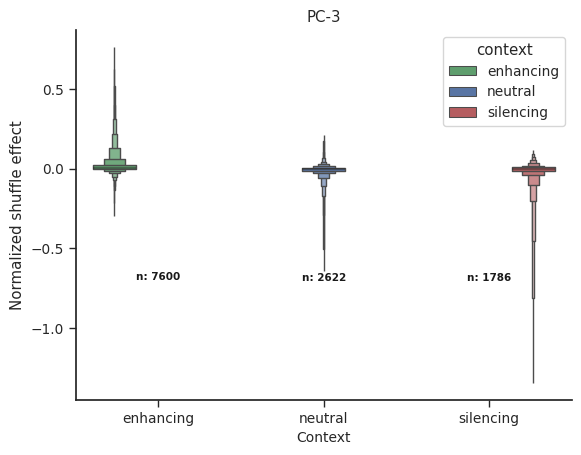

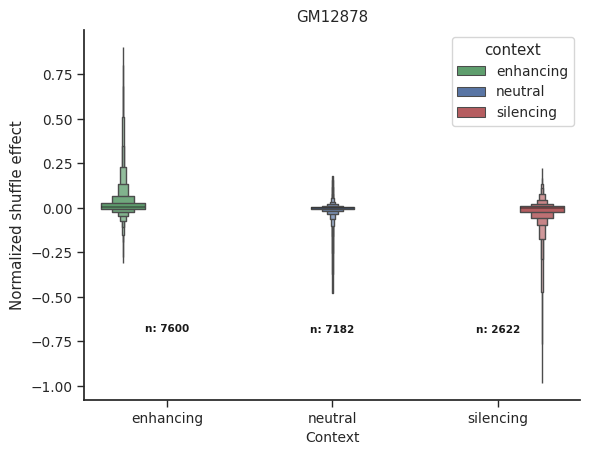

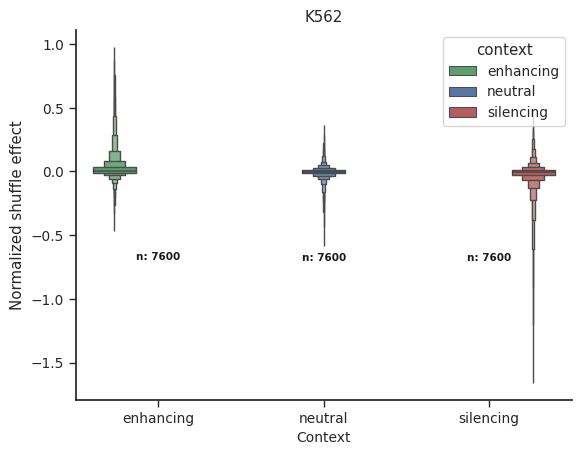

In [75]:
my_pal = {"enhancing": "g", "neutral": "b", "silencing":"r"}
sns.set(font_scale = .9)
sns.set_style(style='white')
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1

plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

for cell, df in result_summary.items():
    ax=sns.boxenplot(x='context', y='Normalized shuffle effect', data=df, 
                  showfliers=False,
                  hue='context',
                  palette = my_pal)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('Context', fontsize=10)

    # add number of observations in each box
    medians = df.groupby(['context'])['Normalized shuffle effect'].median().values
    nobs = df['context'].value_counts().values
    nobs = [str(x) for x in nobs.tolist()]
    nobs = ["n: " + i for i in nobs]

    # Add it to the plot
    pos = range(len(nobs))
    for tick,label in zip(pos,ax.get_xticklabels()):
        ax.text(pos[tick],
                medians[tick] - .7,
                nobs[tick],
                horizontalalignment='center',
                size='x-small',
                color='k',
                weight='semibold')
    plt.title(cell)
    plt.show()
    

In [77]:
df

,Normalized shuffle effect,seq_id,tile_start,tile_end,context,cell_line
0,-0.006986,DAPK1_chr9_87497866_+,804,5804,enhancing,K562
1,0.011106,DAPK1_chr9_87497866_+,5804,10804,enhancing,K562
2,0.001816,DAPK1_chr9_87497866_+,10804,15804,enhancing,K562
3,-0.000423,DAPK1_chr9_87497866_+,15804,20804,enhancing,K562
4,-0.002954,DAPK1_chr9_87497866_+,20804,25804,enhancing,K562
...,...,...,...,...,...,...
33,-0.002138,ACSL6_chr5_131994579_-,170804,175804,silencing,K562
34,-0.014060,ACSL6_chr5_131994579_-,175804,180804,silencing,K562
35,0.001644,ACSL6_chr5_131994579_-,180804,185804,silencing,K562
36,-0.109519,ACSL6_chr5_131994579_-,185804,190804,silencing,K562


In [79]:
selected_cres = []
for cell, df in result_summary.items():
    df['cell_line'] = cell
    enh_df = df[(df['Normalized shuffle effect'] > 0.3) & (df['context']=='enhancing')]
    enh_df['tile class'] = 'Enhancer'
    selected_cres.append(enh_df)
    sil_df = df[(df['Normalized shuffle effect'] < -0.3) & (df['context']=='silencing')]
    sil_df['tile class'] = 'Silencer'
    selected_cres.append(sil_df)
selected_cres = pd.concat(selected_cres)

/tmp/ipykernel_184734/399000856.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  enh_df['tile class'] = 'Enhancer'
/tmp/ipykernel_184734/399000856.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sil_df['tile class'] = 'Silencer'
/tmp/ipykernel_184734/399000856.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

In [81]:
selected_cres.groupby(['cell_line', 'tile class', 'context']).count()

Normalized shuffle effect  seq_id  tile_start   
cell_line tile class context                                                    
GM12878   Enhancer   enhancing                        159     159         159  \
          Silencer   silencing                         40      40          40   
K562      Enhancer   enhancing                        226     226         226   
          Silencer   silencing                        158     158         158   
PC-3      Enhancer   enhancing                        136     136         136   
          Silencer   silencing                         41      41          41   

                                tile_end  
cell_line tile class context              
GM12878   Enhancer   enhancing       159  
          Silencer   silencing        40  
K562      Enhancer   enhancing       226  
          Silencer   silencing       158  
PC-3      Enhancer   enhancing       136  
          Silencer   silencing        41

In [82]:
selected_cres.to_csv('../results/necessity_test/enformer_selected_cres.csv')

# Sufficiency

In [83]:
test_results = glob.glob('../results/sufficiency_test/enformer/*pickle')

In [84]:
track_index = [4824, 5110, 5111]
bin_index = [447, 448]
target_df = pd.read_csv(f'../data/enformer_targets_human.txt', sep='\t')
cell_lines = [utils.clean_cell_name(target_df.iloc[t]['description']) for t in track_index]

In [85]:
tile_coords = pd.read_csv('../results/sufficiency_test/enformer/tile_coordinates.csv', index_col='Unnamed: 0').T
cre_tile_coords = tile_coords.loc[[t for t in tile_coords.index if 'tss' not in t]]

In [104]:
result_summary = {}
for c, cell_line in enumerate(cell_lines):
    normalized_effects = []
    cell_line_context = pd.read_csv(f'../results/context_dependence_test/enformer/{cell_line}_context.csv')
    print(c, cell_line)
    for _, row in cell_line_context.iterrows():
        res_path = row['path'].replace('context_dependence_test', 'sufficiency_test')
        res = utils.read_pickle(res_path) 
        res['wt'] = res['wt'][bin_index, c].mean(axis=0)
        res['mut'] = res['mut'][:, bin_index, c].mean(axis=1)
        res['control'] = res['control'][:, bin_index, c].mean(axis=1)
        # one_seq = pd.DataFrame((res['mut'] - res['control']) / res['wt'])
        one_seq = pd.DataFrame((res['mut']-res['control']) / res['wt'])

        one_seq.columns = ['(MUT - CONTROL) / WT']
        one_seq['(MUT - CONTROL) / CONTROL'] = (res['mut']-res['control']) / res['control']
        one_seq['seq_id'] = res_path.split('/')[-1].split('.')[0]
        one_seq['control'] = res['control']
        one_seq['wt'] = res['wt']
        one_seq['mut'] = res['mut']
        one_seq['tile_start'] = cre_tile_coords[0].values
        one_seq['tile_end'] = cre_tile_coords[1].values
        one_seq['context'] = row['context']
        normalized_effects.append(one_seq)
    result_summary[cell_line] = pd.concat(normalized_effects)

0 PC-3
1 GM12878
2 K562


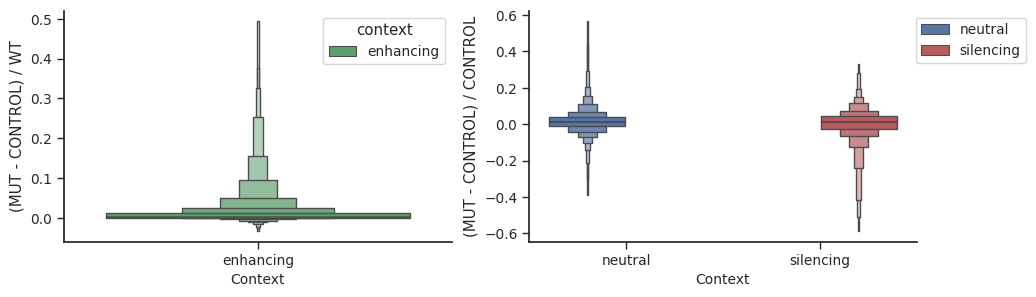

<Figure size 640x480 with 0 Axes>

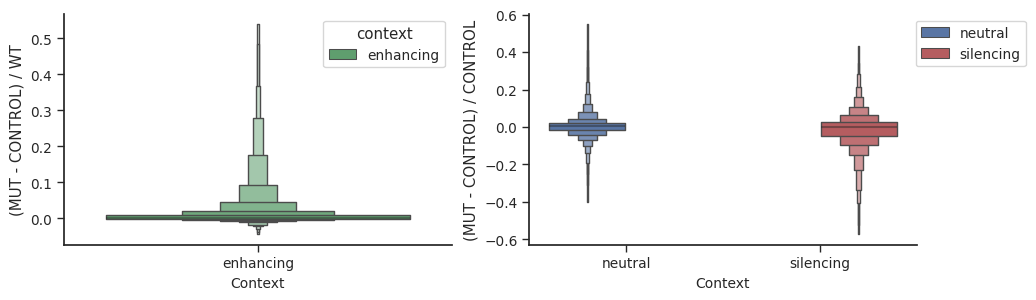

<Figure size 640x480 with 0 Axes>

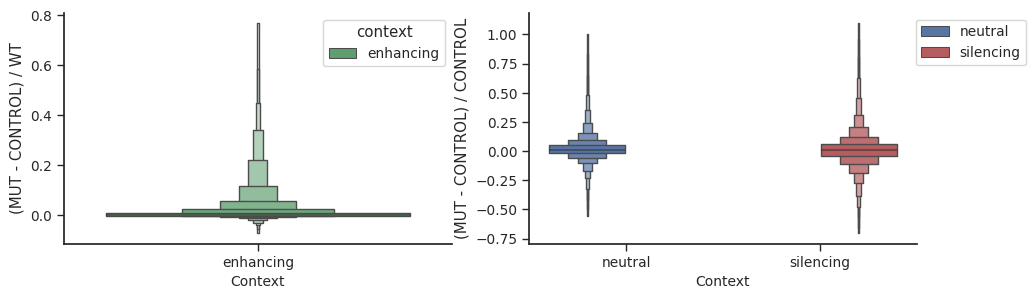

<Figure size 640x480 with 0 Axes>

In [105]:
my_pal = {"enhancing": "g", "neutral": "b", "silencing":"r"}
sns.set(font_scale = .9)
sns.set_style(style='white')
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1

plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True


for cell, df in result_summary.items():
    fig, axes = plt.subplots(1, 2, figsize=[11, 3])
    enh_cont = df[df['context'] == 'enhancing']
    others = df[df['context'] != 'enhancing']
    for p, (df_cont, y) in enumerate([[enh_cont, '(MUT - CONTROL) / WT'],
                                     [others, '(MUT - CONTROL) / CONTROL']]):
        ax = axes[p]
        sns.boxenplot(x='context', y=y, data=df_cont, 
                      showfliers=False,
                      hue='context',
                      ax=ax,
                      palette = my_pal)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xlabel('Context', fontsize=10)
        
    plt.legend(bbox_to_anchor=[1.3,1])
    plt.show()
    plt.tight_layout()


        # add number of observations in each box
    # medians = df.groupby(['context'])[y].median().values
    # nobs = df['context'].value_counts().values
    # nobs = [str(x) for x in nobs.tolist()]
    # nobs = ["n: " + i for i in nobs]

    # # Add it to the plot
    # pos = range(len(nobs))
    # for tick,label in zip(pos,ax.get_xticklabels()):
    #     ax.text(pos[tick],
    #             medians[tick] - .7,
    #             nobs[tick],
    #             horizontalalignment='center',
    #             size='x-small',
    #             color='k',
    #             weight='semibold')
    # plt.title(cell)
    # # plt.ylim(0, 5)
    # plt.show()
    

In [106]:
result_summary['PC-3']

,(MUT - CONTROL) / WT,(MUT - CONTROL) / CONTROL,seq_id,control,wt,mut,tile_start,tile_end,context
0,0.001115,0.015600,PPIC_chr5_123036725_-,9.804421,137.146545,9.957375,804,5804,enhancing
1,-0.001639,-0.022846,PPIC_chr5_123036725_-,9.838990,137.146545,9.614213,5804,10804,enhancing
2,0.007889,0.118512,PPIC_chr5_123036725_-,9.129666,137.146545,10.211637,10804,15804,enhancing
3,0.006734,0.094271,PPIC_chr5_123036725_-,9.796084,137.146545,10.719566,15804,20804,enhancing
4,0.004195,0.062240,PPIC_chr5_123036725_-,9.244544,137.146545,9.819927,20804,25804,enhancing
...,...,...,...,...,...,...,...,...,...
33,0.025122,0.015849,ASDURF_chr2_189661520_+,128.037201,80.774239,130.066437,170804,175804,silencing
34,0.039969,0.024266,ASDURF_chr2_189661520_+,133.044250,80.774239,136.272736,175804,180804,silencing
35,0.090843,0.053920,ASDURF_chr2_189661520_+,136.086777,80.774239,143.424591,180804,185804,silencing
36,0.045026,0.027363,ASDURF_chr2_189661520_+,132.915070,80.774239,136.552017,185804,190804,silencing


In [107]:
12008 / 38

316.0

# threshold CREs for distance test

In [108]:
selected_cres = []
for cell, df in result_summary.items():
    df['cell_line'] = cell
    enh_cont_df = df[df['context']=='enhancing'] # only select enhancing CREs in enhancing contexts
    sil_cont_df = df[df['context']=='silencing'] # only select silencing CREs in silencing contexts
    enh_cont_df['Normalized CRE effect'] = enh_cont_df['(MUT - CONTROL) / WT'] # different norm for tiles from enh vs sil
    sil_cont_df['Normalized CRE effect'] = sil_cont_df['(MUT - CONTROL) / CONTROL']
    
    enh_cres = enh_cont_df[(enh_cont_df['Normalized CRE effect'] > 0.3)] 
    enh_cres['tile class'] = 'Enhancer'
    selected_cres.append(enh_cres)
    sil_cres = sil_cont_df[(sil_cont_df['Normalized CRE effect'] < -0.3)]
    sil_cres['tile class'] = 'Silencer'
    selected_cres.append(sil_cres)
selected_cres = pd.concat(selected_cres)

/tmp/ipykernel_184734/188955257.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  enh_cont_df['Normalized CRE effect'] = enh_cont_df['(MUT - CONTROL) / WT'] # different norm for tiles from enh vs sil
/tmp/ipykernel_184734/188955257.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sil_cont_df['Normalized CRE effect'] = sil_cont_df['(MUT - CONTROL) / CONTROL']
/tmp/ipykernel_184734/188955257.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

In [98]:
selected_cres.groupby(['cell_line', 'tile class', 'context']).count()

(MUT - CONTROL) / WT   
cell_line tile class context                           
GM12878   Enhancer   enhancing                    46  \
          Silencer   silencing                    52   
K562      Enhancer   enhancing                    77   
          Silencer   silencing                   210   
PC-3      Enhancer   enhancing                    36   
          Silencer   silencing                    43   

                                (MUT - CONTROL) / CONTROL  seq_id  control   
cell_line tile class context                                                 
GM12878   Enhancer   enhancing                         46      46       46  \
          Silencer   silencing                         52      52       52   
K562      Enhancer   enhancing                         77      77       77   
          Silencer   silencing                        210     210      210   
PC-3      Enhancer   enhancing                         36      36       36   
          Silencer   silencing                         43      43       43   

                                 wt  tile_start  tile_end   
cell_line tile class context                                
GM12878   Enhancer   enhancing   46          46        46  \
          Silencer   silencing   52          52        52   
K562      Enhancer   enhancing   77          77        77   
          Silencer   silencing  210         210       210   
PC-3      Enhancer   enhancing   36          36        36   
          Silencer   silencing   43          43        43   

                                Normalized CRE effect  
cell_line tile class context                           
GM12878   Enhancer   enhancing                     46  
          Silencer   silencing                     52  
K562      Enhancer   enhancing                     77  
          Silencer   silencing                    210  
PC-3      Enhancer   enhancing                     36  
          Silencer   silencing                     43

In [9]:
selected_cres.to_csv('../results/sufficiency_test/enformer_selected_cres.csv')

In [99]:
selected_cres_old = pd.read_csv('../results/sufficiency_test/enformer_selected_cres.csv')

In [102]:
selected_cres_old[(selected_cres_old['context']=='silencing') & (selected_cres_old['tile class']=='Silencer')
                    & (selected_cres_old['cell_line']=='K562')]

,Unnamed: 0,Normalized CRE effect,seq_id,tile_start,tile_end,context,cell_line,tile class
1286,23,-0.452357,E2F6_chr2_11466161_-,120804,125804,silencing,K562,Silencer
1287,19,-0.421207,ZNF264_chr19_57191500_+,100804,105804,silencing,K562,Silencer
1288,22,-1.296589,ZNF264_chr19_57191500_+,115804,120804,silencing,K562,Silencer
1289,19,-0.464720,GZF1_chr20_23362181_+,100804,105804,silencing,K562,Silencer
1290,20,-0.617411,ZNF586_chr19_57769654_+,105804,110804,silencing,K562,Silencer
...,...,...,...,...,...,...,...,...
1795,21,-0.774285,TRAPPC2B_chr19_57363566_+,110804,115804,silencing,K562,Silencer
1796,8,-0.324218,ACSL6_chr5_131994579_-,40804,45804,silencing,K562,Silencer
1797,14,-0.786562,ACSL6_chr5_131994579_-,70804,75804,silencing,K562,Silencer
1798,19,-0.580070,ACSL6_chr5_131994579_-,100804,105804,silencing,K562,Silencer


In [110]:
sil = selected_cres[(selected_cres['context']=='silencing') & (selected_cres['tile class']=='Silencer')
                    & (selected_cres['cell_line']=='K562')]

In [114]:
sil.head()

,(MUT - CONTROL) / WT,(MUT - CONTROL) / CONTROL,seq_id,control,wt,mut,tile_start,tile_end,context,cell_line,Normalized CRE effect,tile class
22,-1.296589,-0.522875,ZNF264_chr19_57191500_+,177.184143,71.453003,84.538971,115804,120804,silencing,K562,-0.522875,Silencer
20,-0.617411,-0.356925,ZNF586_chr19_57769654_+,88.023811,50.886555,56.605877,105804,110804,silencing,K562,-0.356925,Silencer
21,-1.540258,-0.695641,ZNF12_chr7_6706923_-,100.424210,45.355522,30.565008,110804,115804,silencing,K562,-0.695641,Silencer
14,-0.699105,-0.413071,STX1A_chr7_73719659_-,23.984364,14.171317,14.077128,70804,75804,silencing,K562,-0.413071,Silencer
18,-1.067891,-0.499408,STX1A_chr7_73719659_-,30.302738,14.171317,15.169321,90804,95804,silencing,K562,-0.499408,Silencer


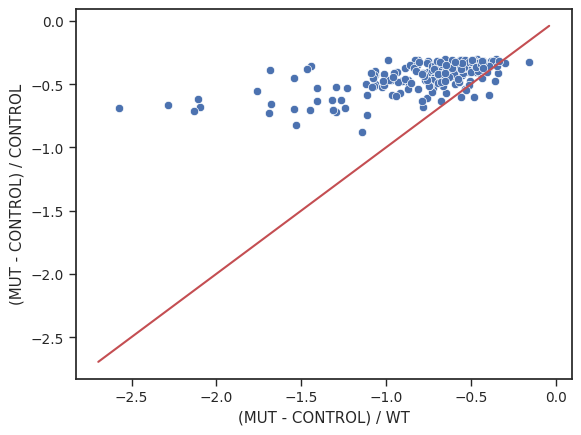

In [120]:
ax=sns.scatterplot(data=sil, x='(MUT - CONTROL) / WT', y='(MUT - CONTROL) / CONTROL')
X_plot = np.linspace(min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1]))
plt.plot(X_plot, X_plot, color='r')

In [128]:
sil[sil['(MUT - CONTROL) / WT'] < -2.5]

,(MUT - CONTROL) / WT,(MUT - CONTROL) / CONTROL,seq_id,control,wt,mut,tile_start,tile_end,context,cell_line,Normalized CRE effect,tile class
21,-2.575021,-0.688734,ZNF599_chr19_34773229_-,78.872345,21.095781,24.550268,110804,115804,silencing,K562,-0.688734,Silencer


In [130]:
sil[np.abs(sil['(MUT - CONTROL) / WT']- sil['(MUT - CONTROL) / CONTROL'])<0.01]

,(MUT - CONTROL) / WT,(MUT - CONTROL) / CONTROL,seq_id,control,wt,mut,tile_start,tile_end,context,cell_line,Normalized CRE effect,tile class
26,-0.533801,-0.541566,ZNF566_chr19_36489435_-,16.374414,16.612587,7.506596,135804,140804,silencing,K562,-0.541566,Silencer
16,-0.512794,-0.509079,ZIM2_chr19_56840726_-,28.674667,28.466919,14.076987,80804,85804,silencing,K562,-0.509079,Silencer
19,-0.405776,-0.403275,CPLX1_chr4_826092_-,17.090450,16.985102,10.198305,100804,105804,silencing,K562,-0.403275,Silencer
21,-0.348705,-0.355745,SLC46A1_chr17_28406201_-,26.084551,26.611160,16.805107,110804,115804,silencing,K562,-0.355745,Silencer


In [131]:
(16.612587 - 16.374414) / 16.612587	

0.014336900086663187

In [133]:
context_effect = pd.read_csv('../results/context_dependence_test/enformer/K562_context.csv')

In [137]:
context_effect[context_effect['path']=='../results/context_dependence_test/enformer/ZNF566_chr19_36489435_-.pickle']

,Unnamed: 0,delta mean,delta std,path,wt,context,cell line
412,275,-0.358565,0.362464,../results/context_dependence_test/enformer/ZN...,16.59892,silencing,K562


In [139]:
res_con = utils.read_pickle('../results/context_dependence_test/enformer/ZNF566_chr19_36489435_-.pickle')

In [149]:
res_con['wt'][[447, 448],0].mean()

9.713743

In [150]:
res_con['mut'][[447, 448],0].mean()

5.4687395

In [162]:
i = 2
creme.context_effect_on_tss(res_con['wt'][[447, 448],i].mean(), res_con['mut'][[447, 448],i].mean())


-0.0061748107

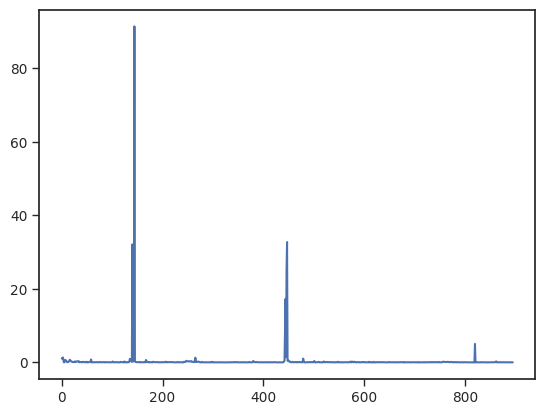

In [155]:
plt.plot(res_con['wt'][:,i])

In [156]:
res_con['wt'][447:449,i]

array([32.73653   ,  0.46131152], dtype=float32)

In [157]:
res_con['mut'][447:449,i]

array([32.608902 ,  0.7939304], dtype=float32)

<Axes: xlabel='Normalized CRE effect', ylabel='Count'>

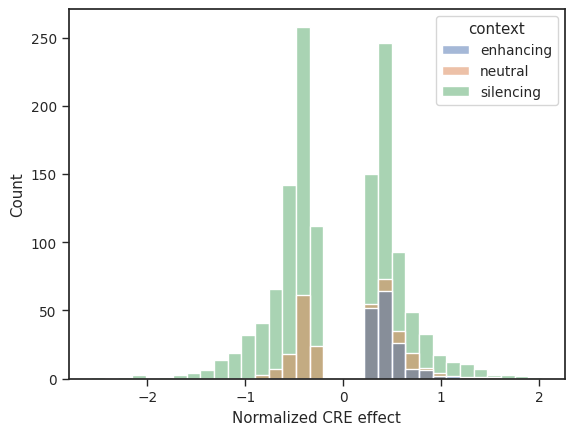

In [10]:
sns.histplot(data=selected_cres, x='Normalized CRE effect', hue='context')

In [214]:
selected_cres

,Normalized CRE effect,seq_id,tile_start,tile_end,context,cell_line
18,0.643710,SIGMAR1_chr9_34635317_-,90804,95804,enhancing,PC-3
18,0.488182,S100A11_chr1_152032505_-,90804,95804,enhancing,PC-3
20,0.393512,ARHGAP11A_chr15_32615503_+,105804,110804,enhancing,PC-3
19,0.391855,PSMD1_chr2_231056893_+,100804,105804,enhancing,PC-3
19,0.309734,APOBEC3C_chr22_39014256_+,100804,105804,enhancing,PC-3
...,...,...,...,...,...,...
21,-1.153904,ZNF570_chr19_37469355_+,110804,115804,silencing,K562
22,-0.341064,ZNF570_chr19_37469355_+,115804,120804,silencing,K562
19,-0.310034,ENSG00000288000_chr20_43458053_+,100804,105804,silencing,K562
23,-0.861627,ENSG00000267179_chr19_11925110_+,120804,125804,silencing,K562


In [147]:
12996 / 38

342.0